<a href="https://colab.research.google.com/github/jetsonai/Working-R-Ssaem/blob/main/LSTM/%5B2%5D_Sequential_Data_Analysis_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kaggle Competition 데이터셋을 활용한 LSTM 실습**

https://www.kaggle.com/competitions/m5-forecasting-accuracy/data

## **전반적인 Sequential Data Analysis 과정**

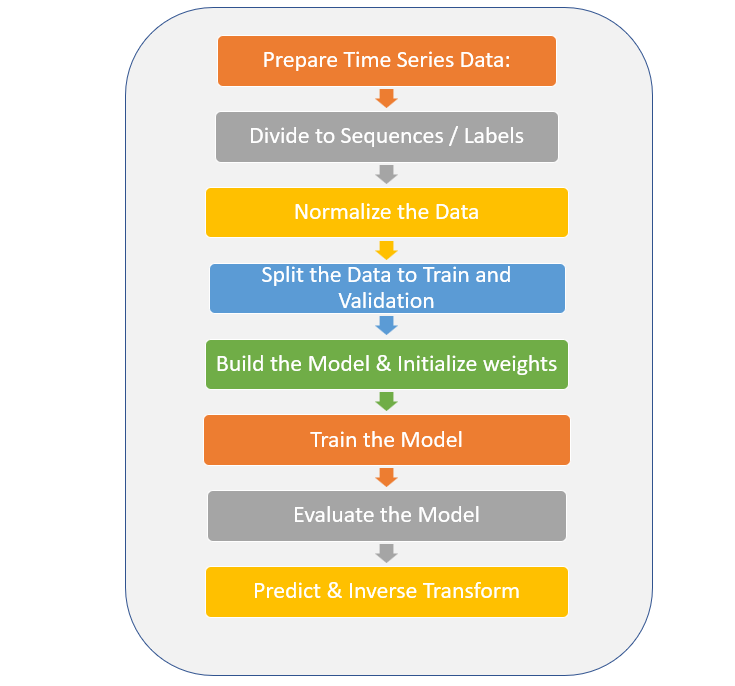

## **사용할 라이브러리 불러오기**

In [ ]:
import time
import os
import warnings
import random
import datetime as dt
from itertools import cycle

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tqdm import tqdm

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.nn as nn

### **라이브러리 및 환경 세팅 진행 (Optional)**

In [ ]:
%matplotlib inline

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

In [ ]:
plt.style.use("bmh")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## **사용 Device 정하기 (GPU 또는 CPU)**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(f"Device Type : {device}")

Device Type : cuda


## **데이터 읽어오기**

In [ ]:
import gdown

file_id = "12bsOLdpVcPAJfkmO6S4QcC8ZcpyeN8QX"
output_file = "m5-forecasting-accuracy.zip"  # Replace "data_file.ext" with the desired output filename and extension

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From (original): https://drive.google.com/uc?id=12bsOLdpVcPAJfkmO6S4QcC8ZcpyeN8QX
From (redirected): https://drive.google.com/uc?id=12bsOLdpVcPAJfkmO6S4QcC8ZcpyeN8QX&confirm=t&uuid=156ee69d-d8b2-45fa-8862-5504e758b5b1
To: /content/m5-forecasting-accuracy.zip
100%|██████████| 48.0M/48.0M [00:00<00:00, 192MB/s]


'm5-forecasting-accuracy.zip'

In [ ]:
!unzip "/content/m5-forecasting-accuracy.zip"

Archive:  /content/m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


### **효율적 데이터 처리를 위한 함수 작성 (Optional)**

In [ ]:
def reduce_memory_usage(df, verbose=True) :
  numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
  start_memory = df.memory_usage().sum()/1024**2

  for col in df.columns :
    col_type = df[col].dtypes
    if col_type in numerics :
      col_min = df[col].min()
      col_max = df[col].max()
      if str(col_type)[:3] == "int" :
        if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max :
          df[col] = df[col].astype(np.int8)
        elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max :
          df[col] = df[col].astype(np.int16)
        elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max :
          df[col] = df[col].astype(np.int32)
        elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max :
          df[col] = df[col].astype(np.int64)
      else:
        if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max :
          df[col] = df[col].astype(np.float16)
        elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max :
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)

  end_memory = df.memory_usage().sum()/1024**2

  if verbose :
    print(f"[Memory Usage] Decreased to {end_memory:.2f} Mb ({(100*(start_memory-end_memory)/start_memory):.2f}% Reduction)")

  return df

In [ ]:
def read_data() :
  sell_prices_df = pd.read_csv("sell_prices.csv")
  sell_prices_df = reduce_memory_usage(sell_prices_df)
  print(f"<Sell Prices> : {sell_prices_df.shape[0]} Rows x {sell_prices_df.shape[1]} Columns")

  calendar_df = pd.read_csv("calendar.csv")
  calendar_df = reduce_memory_usage(calendar_df)
  print(f"<Calendar> : {calendar_df.shape[0]} Rows x {calendar_df.shape[1]} Columns")

  sales_dataset_df = pd.read_csv("sales_train_validation.csv")
  print(f"<Sales Train Validation> : {sales_dataset_df.shape[0]} Rows x {sales_dataset_df.shape[1]} Columns")

  submission_df = pd.read_csv("sample_submission.csv")

  return sell_prices_df, calendar_df, sales_dataset_df, submission_df

In [ ]:
_, calendar_df, sales_dataset_df, _ = read_data()

[Memory Usage] Decreased to 130.48 Mb (37.50% Reduction)
<Sell Prices> : 6841121 Rows x 4 Columns
[Memory Usage] Decreased to 0.12 Mb (41.94% Reduction)
<Calendar> : 1969 Rows x 14 Columns
<Sales Train Validation> : 30490 Rows x 1919 Columns


### **Date 리스트 추가**

In [ ]:
date_index = calendar_df["date"]
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [ ]:
for i in range(10) :
  print(dates_list[i])

2011-01-29
2011-01-30
2011-01-31
2011-02-01
2011-02-02
2011-02-03
2011-02-04
2011-02-05
2011-02-06
2011-02-07


## **데이터셋 시각화 (시계열)**

In [ ]:
sales_dataset_df["item_store_id"] = sales_dataset_df.apply(lambda x: x["item_id"] + "_" + x["store_id"], axis=1)
sales_df = sales_dataset_df.loc[:,"d_1":"d_1913"].T
sales_df.columns = sales_dataset_df["item_store_id"].values

In [ ]:
sales_df = pd.DataFrame(sales_df).set_index([dates_list])
sales_df.index = pd.to_datetime(sales_df.index)
sales_df.head(10)

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,HOBBIES_1_026_CA_1,HOBBIES_1_027_CA_1,HOBBIES_1_028_CA_1,HOBBIES_1_029_CA_1,HOBBIES_1_030_CA_1,HOBBIES_1_031_CA_1,HOBBIES_1_032_CA_1,HOBBIES_1_033_CA_1,HOBBIES_1_034_CA_1,HOBBIES_1_035_CA_1,HOBBIES_1_036_CA_1,HOBBIES_1_037_CA_1,HOBBIES_1_038_CA_1,HOBBIES_1_039_CA_1,HOBBIES_1_040_CA_1,HOBBIES_1_041_CA_1,HOBBIES_1_042_CA_1,HOBBIES_1_043_CA_1,HOBBIES_1_044_CA_1,HOBBIES_1_045_CA_1,HOBBIES_1_046_CA_1,HOBBIES_1_047_CA_1,HOBBIES_1_048_CA_1,HOBBIES_1_049_CA_1,HOBBIES_1_050_CA_1,HOBBIES_1_051_CA_1,HOBBIES_1_052_CA_1,HOBBIES_1_053_CA_1,HOBBIES_1_054_CA_1,HOBBIES_1_055_CA_1,HOBBIES_1_056_CA_1,HOBBIES_1_057_CA_1,HOBBIES_1_058_CA_1,HOBBIES_1_060_CA_1,HOBBIES_1_061_CA_1,HOBBIES_1_062_CA_1,HOBBIES_1_063_CA_1,HOBBIES_1_064_CA_1,HOBBIES_1_065_CA_1,HOBBIES_1_066_CA_1,HOBBIES_1_067_CA_1,HOBBIES_1_068_CA_1,HOBBIES_1_069_CA_1,HOBBIES_1_070_CA_1,HOBBIES_1_072_CA_1,HOBBIES_1_073_CA_1,HOBBIES_1_074_CA_1,HOBBIES_1_075_CA_1,HOBBIES_1_076_CA_1,HOBBIES_1_077_CA_1,HOBBIES_1_078_CA_1,HOBBIES_1_079_CA_1,HOBBIES_1_080_CA_1,HOBBIES_1_081_CA_1,HOBBIES_1_082_CA_1,HOBBIES_1_083_CA_1,HOBBIES_1_084_CA_1,HOBBIES_1_085_CA_1,HOBBIES_1_086_CA_1,HOBBIES_1_087_CA_1,HOBBIES_1_088_CA_1,HOBBIES_1_089_CA_1,HOBBIES_1_090_CA_1,HOBBIES_1_091_CA_1,HOBBIES_1_092_CA_1,HOBBIES_1_093_CA_1,HOBBIES_1_094_CA_1,HOBBIES_1_095_CA_1,HOBBIES_1_097_CA_1,HOBBIES_1_098_CA_1,HOBBIES_1_099_CA_1,HOBBIES_1_100_CA_1,HOBBIES_1_102_CA_1,HOBBIES_1_103_CA_1,HOBBIES_1_104_CA_1,HOBBIES_1_105_CA_1,HOBBIES_1_106_CA_1,HOBBIES_1_107_CA_1,HOBBIES_1_108_CA_1,HOBBIES_1_109_CA_1,HOBBIES_1_110_CA_1,HOBBIES_1_111_CA_1,HOBBIES_1_112_CA_1,HOBBIES_1_113_CA_1,HOBBIES_1_114_CA_1,HOBBIES_1_115_CA_1,HOBBIES_1_116_CA_1,HOBBIES_1_117_CA_1,HOBBIES_1_118_CA_1,HOBBIES_1_119_CA_1,HOBBIES_1_120_CA_1,HOBBIES_1_121_CA_1,HOBBIES_1_122_CA_1,HOBBIES_1_123_CA_1,HOBBIES_1_124_CA_1,HOBBIES_1_125_CA_1,HOBBIES_1_126_CA_1,HOBBIES_1_127_CA_1,HOBBIES_1_128_CA_1,HOBBIES_1_129_CA_1,HOBBIES_1_130_CA_1,HOBBIES_1_131_CA_1,HOBBIES_1_132_CA_1,HOBBIES_1_133_CA_1,HOBBIES_1_134_CA_1,HOBBIES_1_135_CA_1,HOBBIES_1_136_CA_1,HOBBIES_1_137_CA_1,HOBBIES_1_138_CA_1,HOBBIES_1_139_CA_1,HOBBIES_1_140_CA_1,HOBBIES_1_141_CA_1,HOBBIES_1_142_CA_1,HOBBIES_1_143_CA_1,HOBBIES_1_144_CA_1,HOBBIES_1_145_CA_1,HOBBIES_1_146_CA_1,HOBBIES_1_147_CA_1,HOBBIES_1_148_CA_1,HOBBIES_1_149_CA_1,HOBBIES_1_150_CA_1,HOBBIES_1_151_CA_1,HOBBIES_1_152_CA_1,HOBBIES_1_153_CA_1,HOBBIES_1_154_CA_1,HOBBIES_1_155_CA_1,HOBBIES_1_156_CA_1,HOBBIES_1_157_CA_1,HOBBIES_1_158_CA_1,HOBBIES_1_159_CA_1,HOBBIES_1_160_CA_1,HOBBIES_1_161_CA_1,HOBBIES_1_162_CA_1,HOBBIES_1_163_CA_1,HOBBIES_1_164_CA_1,HOBBIES_1_165_CA_1,HOBBIES_1_166_CA_1,HOBBIES_1_167_CA_1,HOBBIES_1_168_CA_1,HOBBIES_1_169_CA_1,HOBBIES_1_170_CA_1,HOBBIES_1_171_CA_1,HOBBIES_1_172_CA_1,HOBBIES_1_173_CA_1,HOBBIES_1_174_CA_1,HOBBIES_1_175_CA_1,HOBBIES_1_176_CA_1,HOBBIES_1_177_CA_1,HOBBIES_1_178_CA_1,HOBBIES_1_179_CA_1,HOBBIES_1_180_CA_1,HOBBIES_1_181_CA_1,HOBBIES_1_183_CA_1,HOBBIES_1_184_CA_1,HOBBIES_1_185_CA_1,HOBBIES_1_186_CA_1,HOBBIES_1_187_CA_1,HOBBIES_1_188_CA_1,HOBBIES_1_189_CA_1,HOBBIES_1_190_CA_1,HOBBIES_1_191_CA_1,HOBBIES_1_192_CA_1,HOBBIES_1_193_CA_1,HOBBIES_1_194_CA_1,HOBBIES_1_195_CA_1,HOBBIES_1_197_CA_1,HOBBIES_1_198_CA_1,HOBBIES_1_199_CA_1,HOBBIES_1_200_CA_1,HOBBIES_1_201_CA_1,HOBBIES_1_202_CA_1,HOBBIES_1_203_CA_1,HOBBIES_1_204_CA_1,HOBBIES_1_205_CA_1,HOBBIES_1_206_CA_1,HOBBIES_1_207_CA_1,HOBBIES_1_208_CA_1,HOBBIES_1_209_CA_1,HOBBIES_1_210_CA_1,HOBBIES_1_211_CA_1,HOBBIES_1_212_CA_1,HOBBIES_1_213_CA_1,HOBBIES_1_214_CA_1,HOBBIES_1_215_CA_1,HOBBIES_1_216_CA_1,HOBBIES_1

In [ ]:
index = 6780

In [ ]:
y = pd.DataFrame(sales_df.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)

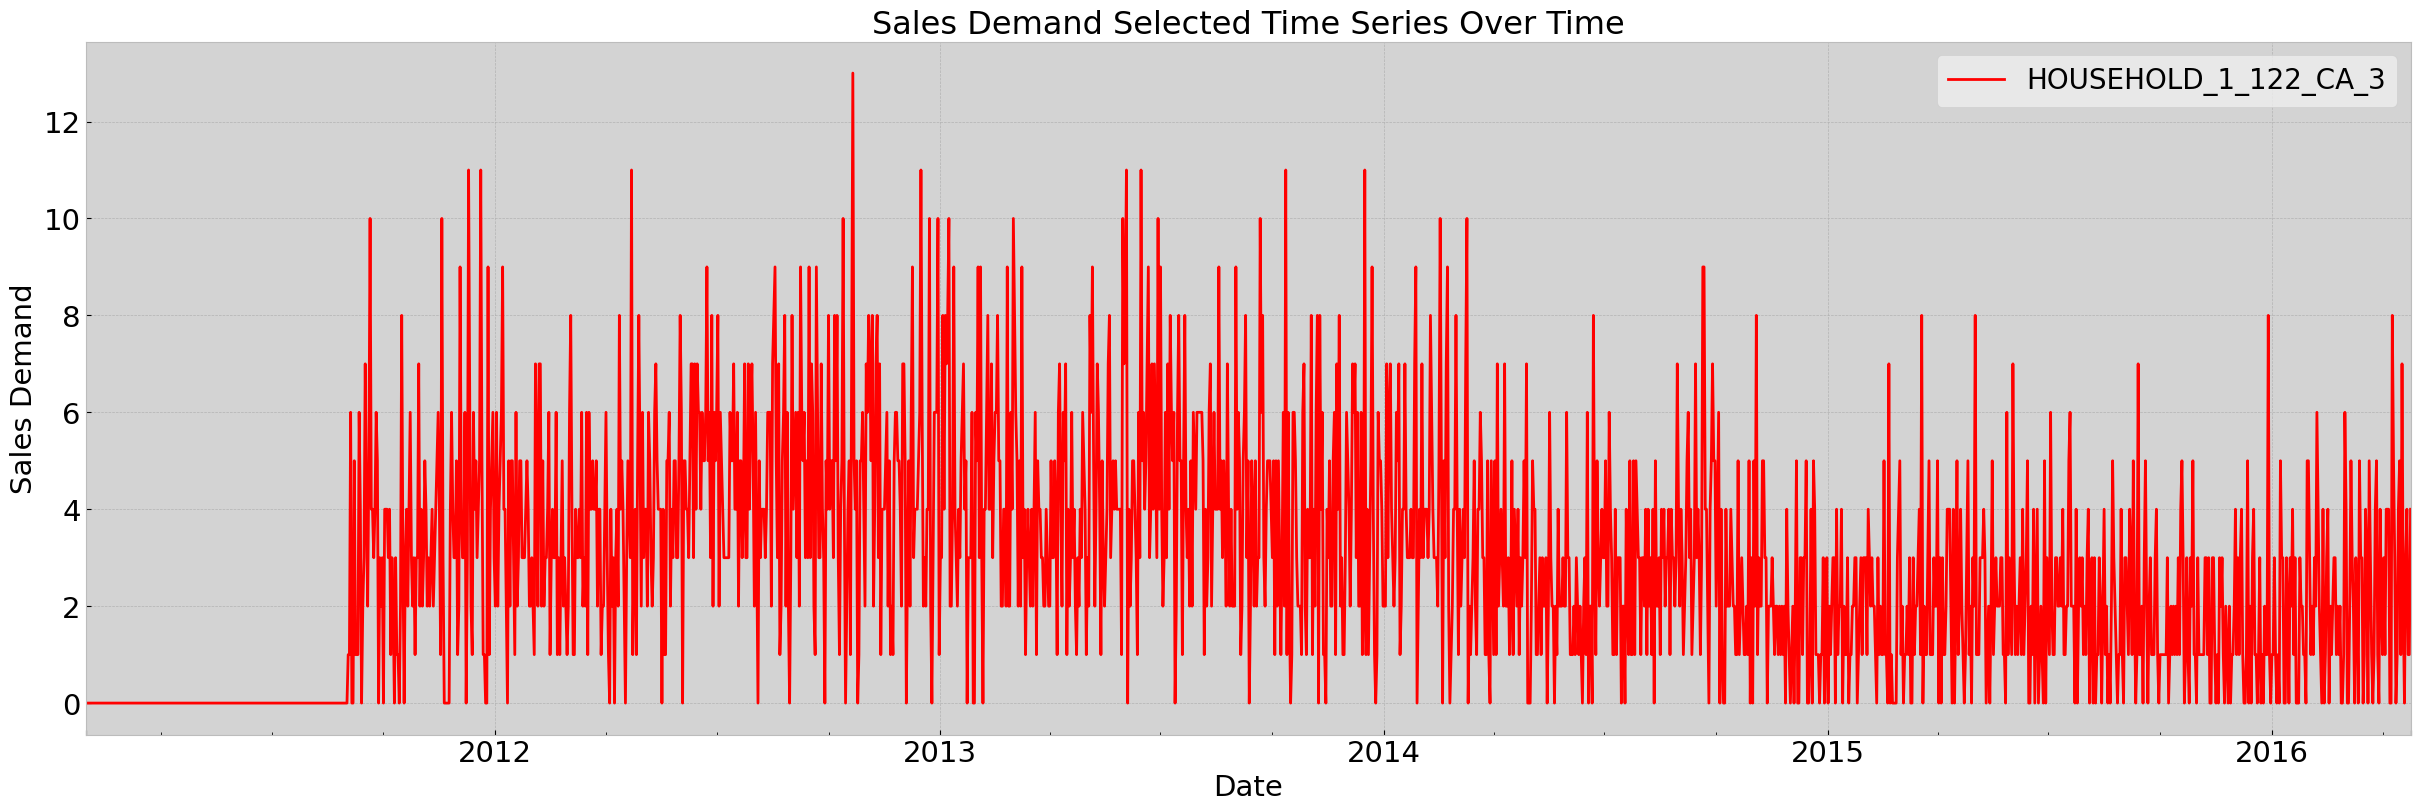

In [ ]:
ax = y.plot(figsize=(30, 9), color="red")
ax.set_facecolor("lightgrey")
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend(fontsize=20)
plt.title(label="Sales Demand Selected Time Series Over Time", fontsize=23)
plt.ylabel(ylabel='Sales Demand',fontsize = 21)
plt.xlabel(xlabel='Date',fontsize = 21)
plt.show()

## **훈련 및 모델 하이퍼파라미터 선정**

In [ ]:
opt = {"seq_len":28, "input_size":1, "hidden_size":512, "num_layer":1, "target_size":1,
       "p":0.25, "num_epoch":500, "lr":1e-3, "seed":42}

## **시드 고정**

In [ ]:
def fix_seed(seed) :
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
fix_seed(opt["seed"])

## **데이터 전처리 과정**

### **Min-Max Normalization**

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1)) # (-1,1) 값으로 Normalization 진행

In [ ]:
data = np.array(y)
train_data_norm = scaler.fit_transform(data.reshape(-1, 1))

In [ ]:
print(f"Mininum Value : {train_data_norm.min()}")
print(f"Maximum Value : {train_data_norm.max()}")

Mininum Value : -1.0
Maximum Value : 1.0


### **데이터 분포 (Histogram) 시각화**

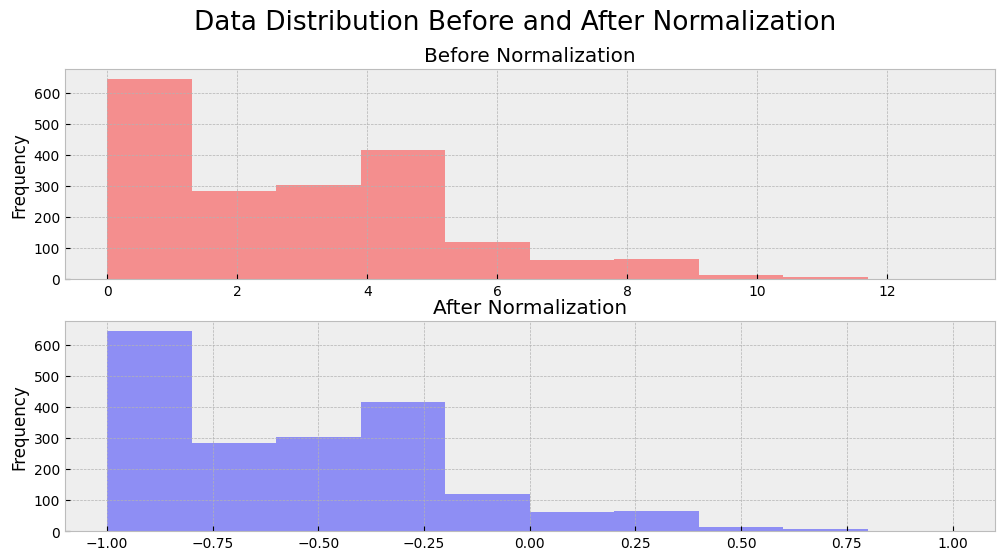

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle("Data Distribution Before and After Normalization",fontsize=19)
pd.DataFrame(data).plot(kind="hist",ax=axs[0], alpha=.4, figsize=[12,6], legend=False, title="Before Normalization", color='red')
pd.DataFrame(train_data_norm).plot(kind="hist", ax=axs[1], figsize=[12,6], alpha=.4, legend=False, title="After Normalization", color="blue")
plt.show()

## **Sequence 데이터 생성 단계**

### 기존 데이터

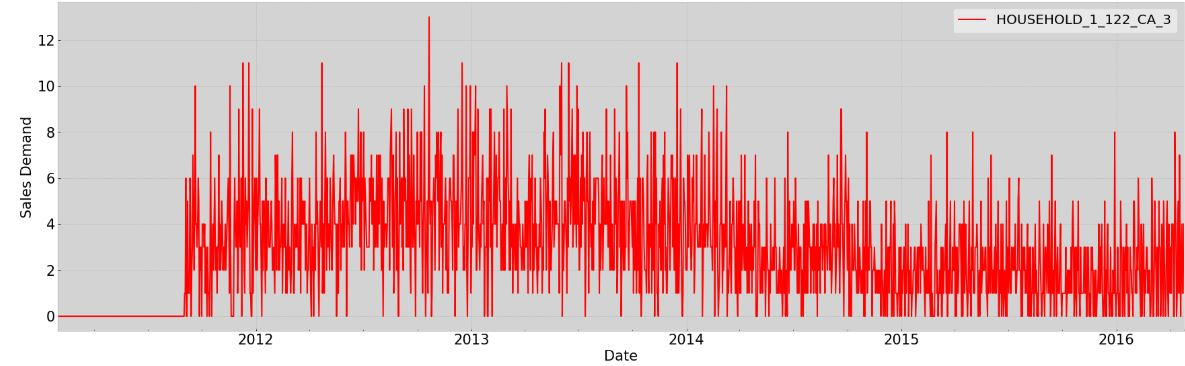

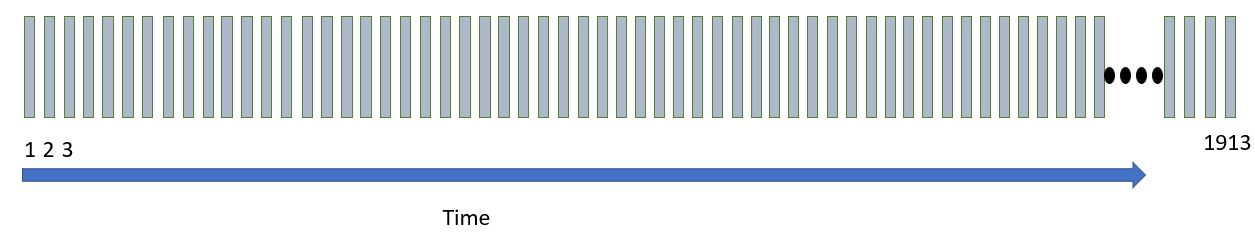

### 1-Step 이동하여 새로운 Input과 Label을 제작 (Sliding Window)

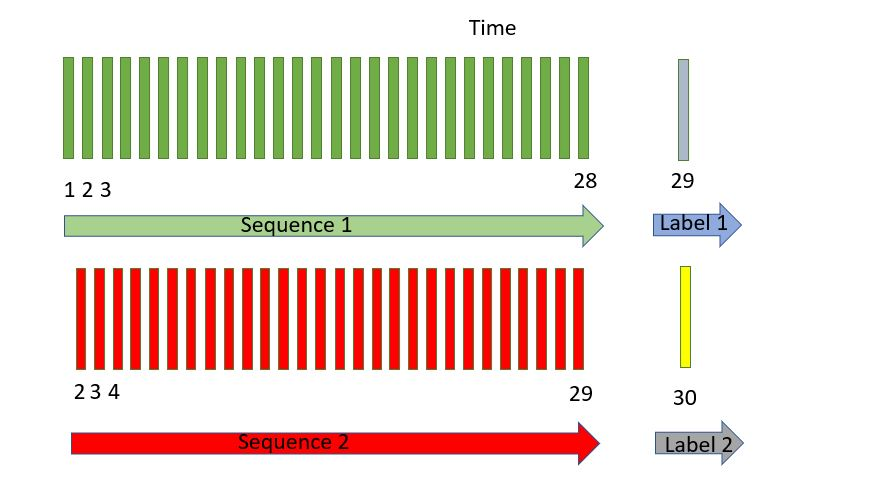

### **Seqeunce 데이터 생성**

In [ ]:
def sliding_windows(data, seq_len) :
  x, y = [], []

  for i in range(len(data)-seq_len-1) :
    x.append(data[i:(i+seq_len)])
    y.append(data[i+seq_len])

  return np.array(x),np.array(y)

In [ ]:
x, y = sliding_windows(train_data_norm, opt["seq_len"])

In [ ]:
print(f"Input Shape : {x.shape}")
print(f"Target Shape : {y.shape}")

Input Shape : (1884, 28, 1)
Target Shape : (1884, 1)


## **PyTorch Tensor 형태의 데이터셋 생성**

In [ ]:
train_size = int(len(y)*0.67)
test_size = len(y)-train_size

In [ ]:
print(f"Train Dataset Size : {train_size}")
print(f"Test Dataset Size : {test_size}")

Train Dataset Size : 1262
Test Dataset Size : 622


### **PyTorch Tensor로 변환**

In [ ]:
data_x = Variable(torch.Tensor(np.array(x))) # 미분 기능
data_y = Variable(torch.Tensor(np.array(y)))

### **데이터셋 Split 과정 진행**

In [ ]:
train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

In [ ]:
test_x = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
test_y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
print(f"Train Dataset Input Size : {train_x.size()}")
print(f"Train Dataset Label Size : {train_y.size()}")
print(f"Test Dataset Input Size : {test_x.size()}")
print(f"Test Dataset Label Size : {test_y.size()}")

Train Dataset Input Size : torch.Size([1262, 28, 1])
Train Dataset Label Size : torch.Size([1262, 1])
Test Dataset Input Size : torch.Size([622, 28, 1])
Test Dataset Label Size : torch.Size([622, 1])


## **LSTM 모델 클래스 정의**

### 기본적인 1-Layer LSTM를 사용

#### Many-to-One 유형

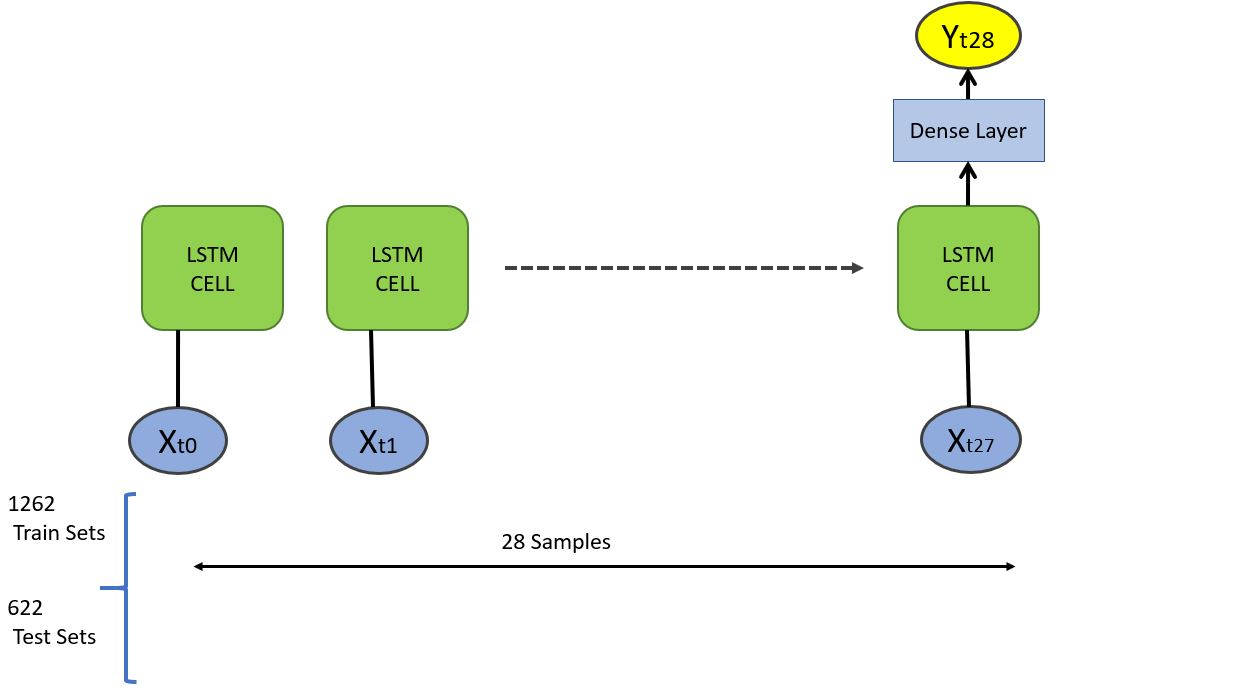

In [ ]:
class LSTM(nn.Module) :
  def __init__(self, input_size, hidden_size, num_layer, target_size, p) :
    # Inheritance
    super(LSTM, self).__init__()

    # Initialize Variables
    self.hidden_size = hidden_size
    self.num_layer = num_layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layer, batch_first=True, dropout=p)
    self.fc = nn.Linear(hidden_size, target_size)
    self.dropout = nn.Dropout(p) # Overfitting을 방지하기 위한 Dropout

  def forward(self, input):
    h0 = torch.zeros(self.num_layer, input.size(0), self.hidden_size).to(input.device)
    c0 = torch.zeros(self.num_layer, input.size(0), self.hidden_size).to(input.device)

    output, _ = self.lstm(input, (h0, c0))
    output = self.fc(output[:, -1, :])
    output = self.dropout(output)

    return output

## **훈련 과정 요약을 위한 Average Meter 인스턴스 생성**

In [ ]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
train_loss, test_loss = AverageMeter(), AverageMeter()

## **훈련 결과 저장을 위한 Python List 인스턴스 생성**

In [ ]:
lstm_train_loss_list, lstm_test_loss_list = [], []

In [ ]:
best_test_loss = torch.inf

## **LSTM 모델 훈련**

### **LSTM 모델 인스턴스 생성**

In [ ]:
fix_seed(opt["seed"])

In [ ]:
model = MultiLSTM(opt["input_size"], opt["hidden_size"], opt["num_layer"], opt["target_size"], opt["p"]).to(device)

NameError: name 'MultiLSTM' is not defined

### **LSTM 모델 파라미터 개수 계산**

In [ ]:
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Numer of Trainable Parameters : {num_param:,}")

### **손실 함수 인스턴스 생성**

In [ ]:
criterion = nn.MSELoss()

### **Optimizer 인스턴스 생성**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt["lr"])

### **훈련 진행**

In [ ]:
with tqdm(total=opt["num_epoch"]) as p_bar :
  for epoch in range(1, opt["num_epoch"]+1) :
    ########################################################################################################################################
    train_loss.reset()

    model.train() # Train Mode

    train_x, train_y = train_x.to(device), train_y.to(device) # Assign Device

    optimizer.zero_grad() # Set Gradient to 0
    pred = model(train_x) # Get Prediction
    loss = criterion(pred, train_y) # Compute Loss
    loss.backward() # Back-Propagation
    optimizer.step() # Update Weight

    train_loss.update(loss.detach().cpu().item()) # Compute Averaged Loss

    lstm_train_loss_list.append(train_loss.avg)

    ########################################################################################################################################

    model.eval() # Evaulation Mode

    test_x, test_y = test_x.to(device), test_y.to(device) # Assign Device

    with torch.no_grad() :
      pred = model(test_x) # Get Prediction
      loss = criterion(pred, test_y) # Compute Loss

      test_loss.update(loss.detach().cpu().item()) # Compute Averaged Loss

    lstm_test_loss_list.append(test_loss.avg)

    if test_loss.avg < best_test_loss :
      best_test_loss = test_loss.avg
      torch.save(model.state_dict(), "Best-LSTM.pth")

    torch.save(model.state_dict(), "Latest-LSTM.pth")

    p_bar.set_description(f"[{epoch}/{opt['num_epoch']}] < Train Loss:{train_loss.avg:.4f} | Test Loss:{test_loss.avg:.4f} >")
    p_bar.update()

## **LSTM 모델 훈련 과정 시각화**

In [ ]:
plt.plot(np.arange(opt["num_epoch"]), lstm_train_loss_list, label="Train Loss")
plt.plot(np.arange(opt["num_epoch"]), lstm_test_loss_list, label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("[LSTM] Train Loss vs. Test Loss")
plt.show()

## **모델 성능 평가**

### **전체 데이터셋을 사용하여 추론 진행**

In [ ]:
model.eval()

In [ ]:
data_y_pred = model(data_x.to(device))
data_y_pred = data_y_pred.cpu().data.numpy()
data_y_target = data_y.data.numpy()

In [ ]:
data_y_pred = scaler.inverse_transform(data_y_pred)
data_y_target = scaler.inverse_transform(data_y_target)

In [ ]:
data_y_pred = pd.DataFrame(data_y_pred)
data_y_pred = data_y_pred.set_index([dates_list[:-29]])
data_y_target = pd.DataFrame(data_y_target)
data_y_target = data_y_target.set_index([dates_list[:-29]])

### **추론 결과 시각화**

In [ ]:
plt.figure(num=None, figsize=(19,6), dpi=80, facecolor="w", edgecolor="k")
plt.axvline(x=dates_list[train_size], c="r")
plt.plot(data_y_target[0])
plt.plot(data_y_pred[0])
plt.legend(["Prediction","Time Series"], fontsize=21)
plt.suptitle("Time-Series Prediction Entire Set", fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel="Sales Demand", fontsize=21)
plt.xlabel(xlabel="Date", fontsize=21)
plt.show()

### **테스트 데이터셋을 사용한 추론 결과 시각화**

In [ ]:
plt.figure(num=None, figsize=(23,6), dpi=80, facecolor="w", edgecolor="k")
plt.plot(data_y_target.iloc[-test_x.size()[0]:][0])
plt.plot(data_y_pred.iloc[-test_x.size()[0]:][0])
plt.legend(["Prediction','Time Series"], fontsize=21)
plt.suptitle("Time-Series Prediction Test", fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel="Sales Demand", fontsize=21)
plt.xlabel(xlabel="Date", fontsize=21)
plt.show()

### **테스트 데이터셋을 사용한 추론 결과의 정량적 분석**

#### **RSME 계산**

In [ ]:
rmse = np.sqrt(np.power(data_y_target[-test_x.size()[0]:]-data_y_pred[-test_x.size()[0]:], 2)).mean()[0]

In [ ]:
print(f"Test RMSE : {rmse:.4f}")

## **LSTM 모델 클래스 정의**

### Multiple-Layer LSTM를 사용

#### Many-to-One 유형

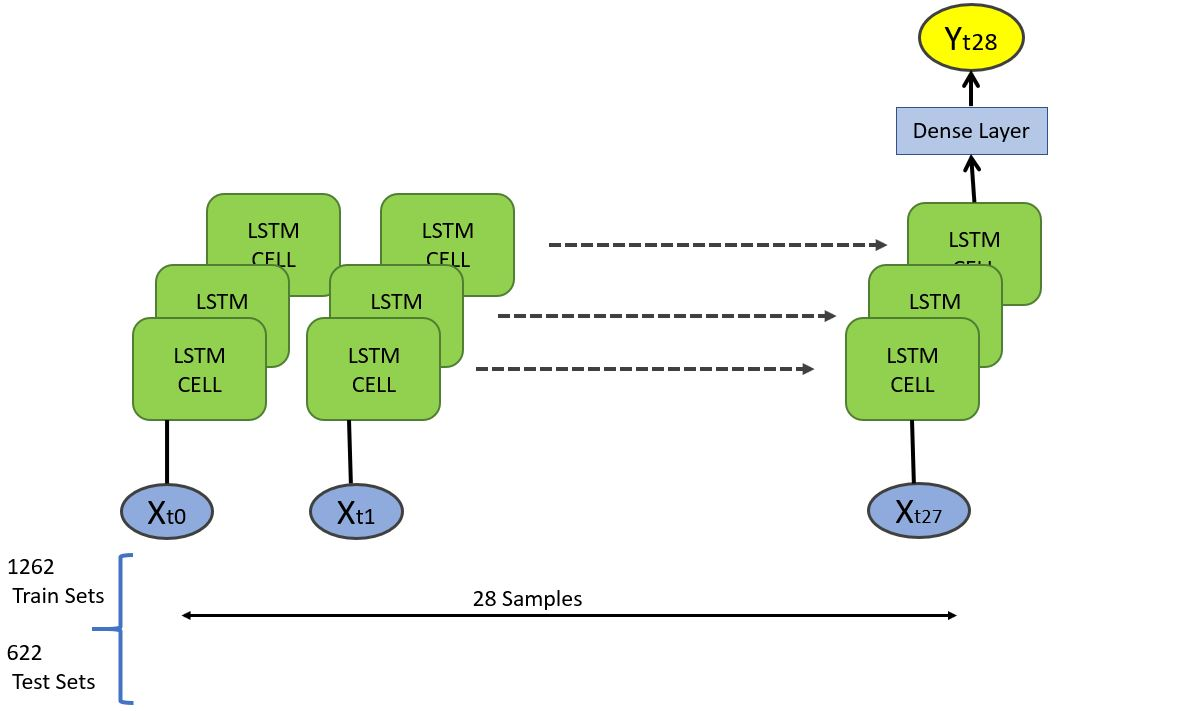

In [ ]:
class MultiLSTM(nn.Module) :
  def __init__(self, input_size, hidden_size, num_layer, target_size, p) :
    # Inheritance
    super(MultiLSTM, self).__init__()

    # Initialize Variables
    self.hidden_size = hidden_size
    self.num_layer = num_layer
    self.lstm = nn.LSTM(input_size, hidden_size, num_layer, batch_first=True, dropout=p)
    self.fc = nn.Linear(hidden_size, target_size)
    self.dropout = nn.Dropout(p) # Overfitting을 방지하기 위한 Dropout

  def forward(self, input):
    h0 = torch.zeros(self.num_layer, input.size(0), self.hidden_size).to(input.device)
    c0 = torch.zeros(self.num_layer, input.size(0), self.hidden_size).to(input.device)

    output, _ = self.lstm(input, (h0, c0))
    output = self.fc(output[:, -1, :])
    output = self.dropout(output)

    return output

## **Multi-Layer LSTM 모델을 만드시고 (Layer=2) MSE Loss로 훈련하세요**

In [ ]:
opt = {"seq_len":28, "input_size":1, "hidden_size":512, "num_layer":2, "target_size":1,
       "p":0.25, "num_epoch":500, "lr":1e-3, "seed":42}

## **LSTM 모델 훈련**

### **LSTM 모델 인스턴스 생성**

In [ ]:
fix_seed(opt["seed"])

In [ ]:
model = LSTM(opt["input_size"], opt["hidden_size"], opt["num_layer"], opt["target_size"], opt["p"]).to(device)

### **LSTM 모델 파라미터 개수 계산**

In [ ]:
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Numer of Trainable Paramerters : {num_param: ,}")

### **손실 함수 인스턴스 생성**

In [ ]:
criterion = nn.MSELoss()

### **Optimizer 인스턴스 생성**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt["lr"])

### **훈련 진행**

In [ ]:
with tqdm(total=opt["num_epoch"]) as p_bar:
  for epoch in range(opt["num_epoch"]) :
    train_loss.reset()

    model.train()

    train_x, train_y = train_x.to(device), train_y.to(device)

    optimizer.zero_grad()
    pred = model(train_x)
    loss = criterion(pred, train_y)
    loss.backward()
    optimizer.step()

    train_loss.update(loss.detach().cpu().item())

    lstm_train_loss_list.append(train_loss.avg)

    model.eval()

    test_x, test_y = test_x.to(device), test_y.to(device)

    with torch.no_grad() :
      pred = model(test_x) # Get Prediction
      loss = criterion(pred, test_y) # Compute Loss

      test_loss.update(loss.detach().cpu().item()) # Compute Averaged Loss

    lstm_test_loss_list.append(test_loss.avg)

    if test_loss.avg < best_test_loss:
      best_test_loss = test_loss.avg
      torch.save(model.state_dict(), "best_model.pth")

    torch.save(model.state_dict(), "last_model.pth")

    p_bar.set_description(f"[{epoch}/{opt['num_epoch']}] < Train Loss:{train_loss.avg:.4f} | Test Loss:{test_loss.avg:.4f} >")
    p_bar.update()


## **LSTM 모델 훈련 과정 시각화**

In [ ]:
print(len(lstm_train_loss_list))
print(len(lstm_test_loss_list))

In [ ]:
import numpy as np

num_epoch = opt["num_epoch"]  # 예: 500
num_batches_per_epoch = len(lstm_train_loss_list) // num_epoch  # 2 (예시)

# numpy로 변환
train_loss_array = np.array(lstm_train_loss_list)  # (1000,)
test_loss_array  = np.array(lstm_test_loss_list)   # (1000,)

# reshape 해서 epoch별 평균으로 묶기
train_loss_per_epoch = train_loss_array.reshape(num_epoch, num_batches_per_epoch).mean(axis=1)
test_loss_per_epoch  = test_loss_array.reshape(num_epoch, num_batches_per_epoch).mean(axis=1)

print(train_loss_per_epoch.shape)  # (500,)
print(test_loss_per_epoch.shape)   # (500,)


In [ ]:
plt.plot(np.arange(num_epoch), train_loss_per_epoch, label="Train Loss")
plt.plot(np.arange(num_epoch), test_loss_per_epoch, label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("[LSTM] Train Loss vs. Test Loss")
plt.show()


## **모델 성능 평가**

### **전체 데이터셋을 사용하여 추론 진행**

In [ ]:
model.eval()

In [ ]:
data_y_pred = model(data_x.to(device))
data_y_pred = data_y_pred.cpu().data.numpy()
data_y_target = data_y.data.numpy()

In [ ]:
data_y_pred = scaler.inverse_transform(data_y_pred)
data_y_target = scaler.inverse_transform(data_y_target)

In [ ]:
data_y_pred = pd.DataFrame(data_y_pred)
data_y_pred = data_y_pred.set_index([dates_list[:-29]])
data_y_target = pd.DataFrame(data_y_target)
data_y_target = data_y_target.set_index([dates_list[:-29]])

### **추론 결과 시각화**

In [ ]:
plt.figure(num=None, figsize=(19,6), dpi=80, facecolor="w", edgecolor="k")
plt.axvline(x=dates_list[train_size], c="r")
plt.plot(data_y_target[0])
plt.plot(data_y_pred[0])
plt.legend(["Prediction","Time Series"], fontsize=21)
plt.suptitle("Time-Series Prediction Entire Set", fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel="Sales Demand", fontsize=21)
plt.xlabel(xlabel="Date", fontsize=21)
plt.show()

### **테스트 데이터셋을 사용한 추론 결과 시각화**

In [ ]:
plt.figure(num=None, figsize=(23,6), dpi=80, facecolor="w", edgecolor="k")
plt.plot(data_y_target.iloc[-test_x.size()[0]:][0])
plt.plot(data_y_pred.iloc[-test_x.size()[0]:][0])
plt.legend(["Prediction','Time Series"], fontsize=21)
plt.suptitle("Time-Series Prediction Test", fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel="Sales Demand", fontsize=21)
plt.xlabel(xlabel="Date", fontsize=21)
plt.show()

### **테스트 데이터셋을 사용한 추론 결과의 정량적 분석**

#### **RSME 계산**

In [ ]:
rmse = np.sqrt(np.power(data_y_target[-test_x.size()[0]:]-data_y_pred[-test_x.size()[0]:], 2)).mean()[0]

In [ ]:
print(f"Test RMSE : {rmse:.4f}")

## **Multi-Layer LSTM 모델을 만드시고 (Layer=2) MAE Loss로 훈련하세요**

In [ ]:
opt = {"seq_len":28, "input_size":1, "hidden_size":512, "num_layer":2, "target_size":1,
       "p":0.25, "num_epoch":500, "lr":1e-3, "seed":42}

## **LSTM 모델 훈련**

### **LSTM 모델 인스턴스 생성**

In [ ]:
fix_seed(opt["seed"])

In [ ]:
model = LSTM(opt["input_size"], opt["hidden_size"], opt["num_layer"], opt["target_size"], opt["p"]).to(device)

### **LSTM 모델 파라미터 개수 계산**

In [ ]:
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"Numer of Trainable Parameters : {num_param:,}")

### **손실 함수 인스턴스 생성**

In [ ]:
criterion = nn.MSELoss()

### **Optimizer 인스턴스 생성**

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=opt["lr"])

### **훈련 진행**

In [ ]:
with tqdm(total=opt["num_epoch"]) as p_bar :
  for epoch in range(1, opt["num_epoch"]+1) :
    ########################################################################################################################################
    train_loss.reset()

    model.train() # Train Mode

    train_x, train_y = train_x.to(device), train_y.to(device) # Assign Device

    optimizer.zero_grad() # Set Gradient to 0
    pred = model(train_x) # Get Prediction
    loss = criterion(pred, train_y) # Compute Loss
    loss.backward() # Back-Propagation
    optimizer.step() # Update Weight

    train_loss.update(loss.detach().cpu().item()) # Compute Averaged Loss

    lstm_train_loss_list.append(train_loss.avg)

    ########################################################################################################################################

    model.eval() # Evaulation Mode

    test_x, test_y = test_x.to(device), test_y.to(device) # Assign Device

    with torch.no_grad() :
      pred = model(test_x) # Get Prediction
      loss = criterion(pred, test_y) # Compute Loss

      test_loss.update(loss.detach().cpu().item()) # Compute Averaged Loss

    lstm_test_loss_list.append(test_loss.avg)

    if test_loss.avg < best_test_loss :
      best_test_loss = test_loss.avg
      torch.save(model.state_dict(), "Best-LSTM.pth")

    torch.save(model.state_dict(), "Latest-LSTM.pth")

    p_bar.set_description(f"[{epoch}/{opt['num_epoch']}] < Train Loss:{train_loss.avg:.4f} | Test Loss:{test_loss.avg:.4f} >")
    p_bar.update()

## **LSTM 모델 훈련 과정 시각화**

In [ ]:
import numpy as np

num_epoch = opt["num_epoch"]  # 예: 500
num_batches_per_epoch = len(lstm_train_loss_list) // num_epoch  # 2 (예시)

# numpy로 변환
train_loss_array = np.array(lstm_train_loss_list)  # (1000,)
test_loss_array  = np.array(lstm_test_loss_list)   # (1000,)

# reshape 해서 epoch별 평균으로 묶기
train_loss_per_epoch = train_loss_array.reshape(num_epoch, num_batches_per_epoch).mean(axis=1)
test_loss_per_epoch  = test_loss_array.reshape(num_epoch, num_batches_per_epoch).mean(axis=1)

print(train_loss_per_epoch.shape)  # (500,)
print(test_loss_per_epoch.shape)   # (500,)


In [ ]:
plt.plot(np.arange(opt["num_epoch"]), lstm_train_loss_list, label="Train Loss")
plt.plot(np.arange(opt["num_epoch"]), lstm_test_loss_list, label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("[LSTM] Train Loss vs. Test Loss")
plt.show()

## **모델 성능 평가**

### **전체 데이터셋을 사용하여 추론 진행**

In [ ]:
# Evaluation Mode로 전환

In [ ]:
# Numpy Array로 데이터 타입 변환

In [ ]:
# Affine (Inverse) Transformation 적용

In [ ]:
# 끝에서 28번째 데이터까지만 사용

### **추론 결과 시각화**

In [ ]:
# 추론 결과 시각화 코드 작성

### **테스트 데이터셋을 사용한 추론 결과 시각화**

In [ ]:
# 추론 결과 시각화 코드 작성

### **테스트 데이터셋을 사용한 추론 결과의 정량적 분석**

#### **RSME 계산**

In [ ]:
# RMSE 계산 코드 작성

In [ ]:
# RMSE 결과 값 출력